# Portfolio Optimization

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize 
%matplotlib inline

In [3]:
Tech_KR =['005930.KS','000660.KS','035420.KS', '035720.KS' ] #Samsung, SK hynix, Naver, Kakao  

def get_price(companies): 
    df=pd.DataFrame()
    for company in companies:
        df[company]=yf.Ticker(company).history(start='2018-04-01', end='2020-03-31')['Close']
    return df

def get_div(companies): 
    df=pd.DataFrame()
    for company in companies:
        df[company]=yf.Ticker(company).history(start='2018-04-01',end='2020-03-31')['Dividends']
    return df  

p_KR=get_price(Tech_KR)
d_KR=get_div(Tech_KR)

p_KR.columns=['SS', 'SKH', 'NVR', 'KKO']
d_KR.columns=['SS', 'SKH', 'NVR', 'KKO']

In [5]:
p_KR.head()

,SS,SKH,NVR,KKO
Date,,,,
2018-04-02,47380.38,79270.88,156585.73,129000.0
2018-04-03,46970.41,79758.41,156585.73,128500.0
2018-04-04,45799.07,78393.34,150402.09,123500.0
2018-04-05,47575.59,80830.95,155388.91,124500.0
2018-04-06,47243.72,78295.84,153593.66,122500.0


--------

## portfolio city

In [4]:
# Generate 3000 random weights to show return and risk
weights=np.random.rand(len(Tech_KR))

# weights must be 1 when combined
weights=weights/np.sum(weights)
weights

array([0.35001869, 0.36077172, 0.2320883 , 0.0571213 ])

In [5]:
# Return for randomly generated random numbers
r_a= (p_KR.iloc[-1]+d_KR.sum())/p_KR.iloc[0]-1
port_return= np.dot(weights, r_a)
port_return

0.0970762145182752

In [6]:
# Risk for randomly generated random numbers
covar_KR=(p_KR/p_KR.shift()-1).cov()*252
port_risk= np.dot(weights.T, np.dot(covar_KR, weights))
port_risk

0.06972621873865027

In [7]:
# Portfolio return and risk according to the combination of weights
port_returns=[]
port_risks=[]
for ii in range(3000):
    weights=np.random.rand(len(Tech_KR))
    weights=weights/np.sum(weights)
    r_a= (p_KR.iloc[-1]+d_KR.sum())/p_KR.iloc[0]-1
    port_return= np.dot(weights, r_a)
    covar_KR=(p_KR/p_KR.shift()-1).cov()*252
    port_risk= np.dot(weights.T, np.dot(covar_KR, weights))
    port_returns.append(port_return)
    port_risks.append(port_risk)



In [23]:
port_returns = np.array(port_returns)
port_risks= np.array(port_risks)

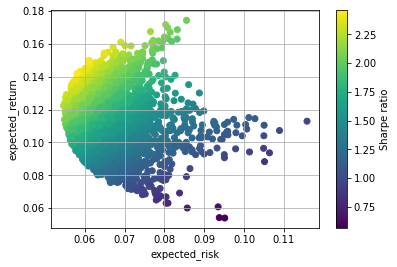

In [24]:
plt.scatter(port_risks, port_returns, c=port_returns/port_risks)
plt.colorbar(label='Sharpe ratio')
plt.xlabel('expected_risk')
plt.ylabel('expected_return')
plt.grid(True)
plt.show()

------

## Define the optimization problem
- Objective function: Sharpe ratio (max), Risk (min)
- Optional variable: weights
- Constraint: the sum of all weights is 1
- Boundary: Each weight is between 0 and 1.

## Portfolio Optimization: Finding Three Points
- Minimum portfolio risk
- Max Sharpe Index
- Efficient investment point: A portfolio that can have the minimum risk to achieve the target return

In [9]:
#minimize(objective function, w0, constraints=, bounds= )

In [10]:
# Define the objective function
# First, if you put weights, define a function that returns rist, return, and sharpe raio => Define an objective function
def get_stats(weights):
    r_a= (p_KR.iloc[-1]+d_KR.sum())/p_KR.iloc[0]-1
    port_return= np.dot(weights, r_a)
    covar_KR=(p_KR/p_KR.shift(1)-1).cov()*252
    port_risk= np.dot(weights.T, np.dot(covar_KR, weights))
    port_sharpe= port_return/ port_risk 
    return [port_return, port_risk, port_sharpe]

def objective_return(weights):
    return -get_stats(weights)[0]

def objective_risk(weights):
    return get_stats(weights)[1]

def objective_sharpe(weights):
    return -get_stats(weights)[2]

In [11]:
get_stats(weights)

[0.1291941702770169, 0.06897930803689836, 1.8729409435059634]

In [12]:
# define w0
w0=np.ones(len(Tech_KR))/len(Tech_KR)

In [13]:
# constraints
constraints={'type':'eq', 'fun': lambda x: np.sum(x)-1 }

In [14]:
# bounds
bound=(0,1)
bounds= tuple(bound for ii in range(len(Tech_KR)))

In [15]:
bounds

((0, 1), (0, 1), (0, 1), (0, 1))

In [16]:
# Optimization 1. Minimum Risk
opt_risk = minimize(objective_risk, w0, constraints=constraints, bounds=bounds)
# Optimization 2. max Sharp ration 
opt_sharpe= minimize(objective_sharpe, w0, constraints=constraints, bounds=bounds )

In [20]:
opt_risk

     fun: 0.05447379098832997
     jac: array([0.10889659, 0.11538666, 0.1085864 , 0.10935601])
 message: 'Optimization terminated successfully'
    nfev: 35
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.52076309, 0.        , 0.219825  , 0.25941191])

In [17]:
# Optimized risk
print(opt_risk['fun'])

# weights at that time (portfolio)
print(opt_risk['x']) 

0.05447379098832997
[0.52076309 0.         0.219825   0.25941191]


In [21]:
opt_sharpe

     fun: -2.4715832411464684
     jac: array([2.47340509, 3.09203136, 2.47240958, 2.46969274])
 message: 'Optimization terminated successfully'
    nfev: 33
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([5.06138576e-01, 6.46119613e-17, 3.40081441e-03, 4.90460610e-01])

In [19]:
# Optimized sharpe ratio
print(-opt_sharpe['fun'])

# weights at that time (portfolio)
(opt_sharpe['x'])

2.4715832411464684


array([5.06138576e-01, 6.46119613e-17, 3.40081441e-03, 4.90460610e-01])

--------------------

## View Optimized Sharp ratio and Sharp risk

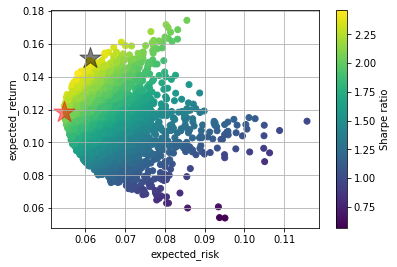

In [25]:
plt.scatter(port_risks, port_returns, c=port_returns/port_risks)
plt.colorbar(label='Sharpe ratio')
pt_opt_sharpe=get_stats(opt_sharpe['x'])
plt.scatter(pt_opt_sharpe[1], pt_opt_sharpe[0], marker='*', s=500, c='black', alpha=0.5)
pt_opt_risk=get_stats(opt_risk['x'])
plt.scatter(pt_opt_risk[1], pt_opt_risk[0], marker='*', s=500, c='red', alpha=0.5)
plt.xlabel('expected_risk')
plt.ylabel('expected_return')
plt.grid(True)
plt.show()

In [26]:
# Efficient investment point: A portfolio that has the minimum risk to achieve the target return.
target_returns= np.linspace(0.14, 0.23, 50)

In [27]:
target_risks=[]
target_port={}
for target_return in target_returns:
    constraints= ({'type':'eq', 'fun': lambda x: np.sum(x)-1 }, 
                {'type':'eq', 'fun': lambda x:get_stats(x)[0]-target_return})
    opt_target=minimize(objective_risk, w0, constraints=constraints, bounds=bounds)
    target_risks.append(opt_target['fun'])
    target_port[target_return]=opt_target['x']

target_risks=np.array(target_risks)

-----------------

## Portfolio construction

<AxesSubplot:>

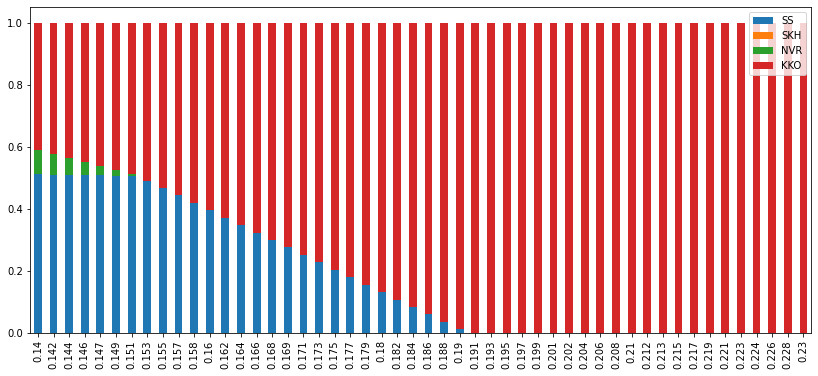

In [28]:
w=pd.DataFrame(target_port.values())
w.columns=['SS', 'SKH', 'NVR', 'KKO']
w.index=target_returns.round(3)
w.plot(figsize=(14,6), kind='bar', stacked=True)

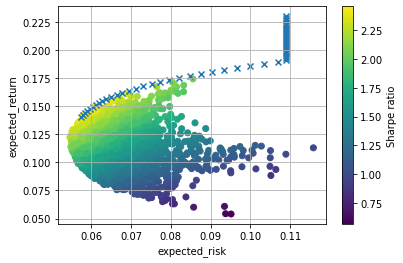

In [29]:
plt.scatter(port_risks, port_returns, c=port_returns/port_risks)
plt.colorbar(label='Sharpe ratio')
plt.scatter(target_risks, target_returns, marker='x')
plt.xlabel('expected_risk')
plt.ylabel('expected_return')
plt.grid(True)
plt.show()